<a id="inicio"></a>
<img src="http://www.cidaen.es/assets/img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">




<br><br><br>
<h2><font color="#00586D" size=4>Capstone V (2)</font></h2>

<h1><font color="#00586D" size=5>Análisis y predicción de un conjunto de datos sobre precios de viviendas</font></h1>
<br><br><br>


<div align="right">
<font color="#00586D" size=3>Luis de la Ossa</font><br>
<font color="#00586D" size=3>Máster en Ciencia de Datos e Ingeniería de Datos en la Nube</font><br>
<font color="#00586D" size=3>Universidad de Castilla-La Mancha</font>

</div>
<br>

<div align="left">
<font color="#000000" size=3>Marta Bellón Castro</font><br>
<font color="#000000" size=3>Curso 2022-2023</font><br>
</div>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import numpy as np
import pandas as pd

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

<a id="indice"></a>
<h2><font color="#00586D" size=5>Índice</font></h2>

#### <font color="#00586D"> Notebook I</font>
* [1. Introducción](#section1)
* [2. Preparación de los datos](#section2)
* [3. Exploración preliminar](#section3)

#### <font color="#00586D"> Notebook II</font>
* [4. Predicción con modelos básicos](#section4)
* [5. Ensembles](#section5)
* [6. Explicabilidad](#section6)
* [7. KNN](#section7)
* [8. Construcción de características](#section8)
* [9. Descarte de outliers](#section9)
* [10. Aprendizaje no supervisado: PCA, Manifold y EM](#section10)


---
<br>

En este proyecto se aborda un problema de análisis y predicción de precios de viviendas a partir de un conjunto de datos que se ha obtenido de [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). En la libreta anterior, se preprocesaron estos datos y se hizo una pequeña exploración. El resultado se almacenó en el archivo  `data/houses_prep.csv`. En esta libreta se llevará a cabo el desarrollo del proyecto.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>  A diferencia de proyectos anteriores, en este caso no se trabajará en pasos sucesivos hasta lograr un objetivo, sino que se resolverán ejercicios de distinta índole relacionados con algunas de las técnicas vistas en clase. Por otra parte, **aunque la lectura del proyecto es larga, los ejercicios son cortos** (relativamente 🤓).
</div>


In [2]:
data = pd.read_csv('data/houses_prep.csv', index_col=0, na_values='NA')
#df_houses.info()
data.shape

(1460, 227)

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section4"></a>
## <font color="#00586D"> 4. Predicción con modelos básicos</font>
<br>

En este apartado se implementarán unos modelos básicos iniciales sobre los que se trabajará posteriormente para intentar refinar el modelo. A continuación, se crean los conjuntos de datos de entrenamiento y test (33% de los datos). Debido a que el conjunto de datos es pequeño, se utilizará validación cruzada para seleccionar el modelo y determinar los parámetros. 

In [3]:
from sklearn.model_selection import train_test_split

X = data.drop(columns='SalePrice').copy()
y = data['SalePrice'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

print(X_train.shape)
print(X_test.shape)

(978, 226)
(482, 226)


Para simplificar el código se proporciona una función auxiliar que muestra los resultados de un modelo con respecto a entrenamiento, validación, y test. El parámetro `is_log` permite indicar si se ha pasado el logaritmo de la clase como variable objetivo (veremos después por qué).  Por otra parte, los resultados de los algoritmos se irán almacenando en un *DataFrame* denominado `results` con el fin de que se puedan visualizar fácilmente. Es importante que el nombre del modelo (primer parámetro de la función, `description`) sea representativo y único.

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error


# DataFrame con los resultados
results = pd.DataFrame(columns=['Modelo','$R^2$ Entrenamiento','$R^2$ Validación','$R^2$ Test', 
                                         'MAE Entrenamiento', 'MAE Test']).set_index('Modelo')
results

def show_results(description, model, X_train, y_train, X_test, y_test, is_log=False):
    train_r2 = model.score(X_train,y_train)
    val_r2 = cross_val_score(model,X_train,y_train,cv=5).mean()
    test_r2 = model.score(X_test, y_test)
    
    # Si se utiliza el logaritmo de la variable objetivo hay que 
    # convertirlo para calcular el error
    f = np.exp if is_log else lambda y: y
    # Calcula el error    
    train_mae = mean_absolute_error(f(y_train), f(model.predict(X_train)))
    test_mae = mean_absolute_error(f(y_test), f(model.predict(X_test)))
    
    # Muetra los resultados en formato legible
    print('Training \t\txValidation \t\tTest')
    print('-------- \t\t----------- \t\t----')
    print(f"R\u00B2 = {train_r2:.3f}\t\tR\u00B2 = {val_r2:.3f}\t\tR\u00B2 = {test_r2:.3f}")
    print(f"MAE = {train_mae:.2f}\t\t\t\t\tMAE = {test_mae:.2f}")
    
    results.loc[description]= (train_r2, val_r2, test_r2, train_mae, test_mae)

---

### <font color="#00586D">Regresión lineal con regularización</font>
<br>



El modelo básico con el que comenzaremos a trabajar es una regresión lineal con regularización L2 (`Ridge()`). 


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 1</font> 

Entrenar un modelo `Ridge()`. Se utilizará `GridSearchCV` (con 5 particiones) para determinar el valor óptimo de `alpha`. El modelo final se almacenará en la variable `ridge`, y se mostrará el resultado con `show_results`.


<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
__Importante__: Para evaluar y comparar modelos **utizaremos, estrictamente,** los resultados de entrenamiento y validación cruzada. El resultado de test es informativo, y **en ningún momento lo utilizaremos para hacer ajustes**.
</div>

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
 
parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(), parameters, cv=5).fit(X_train, y_train) ###################### COMPLETAR
print(search.best_params_, end='\n\n')

ridge = search.best_estimator_
description = 'Ridge regression'
show_results(description, ridge, X_train, y_train, X_test, y_test)

{'alpha': 10.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.908		R² = 0.846		R² = 0.776
MAE = 15187.84					MAE = 19274.55



Entrenar también un modelo `DecisionTreeRegressor` distintas configuraciones en relación a la profundidad y al número minimo de muestras por hoja. El árbol se almacenará en la variable `tree`. Mostrar los resultados.

In [6]:
from sklearn.tree import DecisionTreeRegressor

parameters = {'max_depth':np.linspace(1,15,15).astype(int), 'min_samples_split':(2,4,6,8,10)}
search = GridSearchCV(DecisionTreeRegressor(random_state=0), parameters, cv=5, refit=True).fit(X_train, y_train)
print(search.best_params_, end='\n\n')

tree = search.best_estimator_
description = 'Regression tree'
show_results(description, tree, X_train, y_train, X_test, y_test)

{'max_depth': 5, 'min_samples_split': 2}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.877		R² = 0.720		R² = 0.747
MAE = 20590.84					MAE = 26399.47


El *DataFrame* `results`muestra ambos resultados. Comentarlos (centraos en el $R^2$ en todos los casos).

In [7]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Ridge regression,0.907758,0.845827,0.775932,15187.837606,19274.550173
Regression tree,0.877226,0.719639,0.746637,20590.843457,26399.467551


___Comentario___

<br><font color='blue'>
    Un valor alto de R2 indica que el modelo puede explicar una mayor parte de la variabilidad de los datos. Es decir, cuanto más alto sea el valor de R2, más ajustado estará el modelo a los datos y mejor podrá predecir valores futuros. 
<br>
    El modelo de Regresión Ridge tiene valores de R2 más altos en todos los conjuntos de datos, lo que indica que puede explicar más la variabilidad en los datos. 
Además, este tiene valores de MAE más bajos tanto en el conjunto de entrenamiento como en el conjunto de prueba, lo que indica que es más preciso en la predicción de los valores de salida. 
    <br>
    Por lo tanto, el modelo de Regresión Ridge parece ser la mejor opción de los dos modelos evaluados.
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section5"></a>
## <font color="#00586D"> 5. Ensembles</font>
<br>

Los ensembles, a pesar de su simplicidad (en algunos casos), son una de las técnicas más utilizadas en aprendizaje. El motivo principal es que sobreajustan menos que otros modelos. En este caso, utilizaremos un *Random Forest* para compararlo con los resultados anteriores. 

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 2</font> 

Entrenar un modelo `RandomForestRegressor`, utilizando validación cruzada para estimar la máxima profundidad. Almacenar el modelo resultante en `rforest` y comentar el resultado.

In [8]:
from sklearn.ensemble import RandomForestRegressor

parameters = {'max_depth':[1,5,10,15,20]}
search = GridSearchCV(RandomForestRegressor(random_state=0), parameters, cv=5, refit=True).fit(X_train, y_train)
print(search.best_params_, end='\n\n')

rforest = search.best_estimator_
description = 'Random forest'
show_results(description, rforest, X_train, y_train, X_test, y_test)

{'max_depth': 15}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.980		R² = 0.858		R² = 0.857
MAE = 6669.43					MAE = 17147.71


In [9]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Ridge regression,0.907758,0.845827,0.775932,15187.837606,19274.550173
Regression tree,0.877226,0.719639,0.746637,20590.843457,26399.467551
Random forest,0.979642,0.857511,0.857280,6669.429578,17147.713288


___Comentario___

<br><font color='blue'>
    El Modelo de Random Forest tiene un mejor rendimiento en términos de 𝑅2 en entrenamiento y test, lo que indica una mejor capacidad para predecir los precios de las viviendas en el conjunto de datos. Además, su MAE es significativamente menor tanto en entrenamiento como en test, lo que indica una mejor precisión en la predicción de los valores. Por lo tanto, se puede decir que el modelo de Random Forest es el mejor de los tres modelos evaluados.`


<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->


Por otra parte, El modelo *Random Forest* obtiene la importancia de las características basándose en la impureza de los árboles (aunque en el artículo original que plantea esta técnica se propone un método basado en permutaciones parecido al que ve en el tema de explicabilidad) y la almacena en el campo `feature_importances_`. A continuación, se obtiene una lista con las (por ejemplo) 20 características más importantes en la predicción y se almacenan en la lista `relevant_feat`. 


In [10]:
relevant_feat = X_train.columns[np.argsort(rforest.feature_importances_)[:-20:-1]].to_list()
print(relevant_feat)

['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', 'GarageArea', 'GarageCars', '1stFlrSF', 'MasVnrArea', 'LotArea', 'YearBuilt', '2ndFlrSF', 'BsmtQual', 'GarageYrBlt', 'BsmtUnfSF', 'LotFrontage', 'KitchenQual', 'MoSold', 'FullBath', 'OpenPorchSF']


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 3</font> 

Volver a entrenar los tres modelos anteriores, pero utilizando solamente las características relevantes (solo cambia que hay que acceder a las columnas al usar los conjuntos de training). Comentar los resultados obtenidos en relación a los obtenidos anteriormente.

In [11]:
# Modifico X_train para usar solo las características relevantes
X_train_relevant = X_train[relevant_feat]
X_test_relevant = X_test[relevant_feat]

In [12]:
parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(random_state=0), parameters, cv=5, refit=True).fit(X_train_relevant, y_train)
print(search.best_params_, end='\n\n')

ridge_rel = search.best_estimator_
description = 'Ridge regression (Relevant)'
show_results(description, ridge_rel, X_train_relevant, y_train, X_test_relevant, y_test)

{'alpha': 10.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.835		R² = 0.817		R² = 0.712
MAE = 21103.54					MAE = 22491.44


In [13]:
parameters = {'max_depth':np.linspace(1,15,15), 'min_samples_split':(2,4,6,8,10)}
search = GridSearchCV(DecisionTreeRegressor(random_state=0), parameters, cv=5, refit=True).fit(X_train_relevant, y_train) 
print(search.best_params_, end='\n\n')

tree_rel = search.best_estimator_
description = 'Regression tree (Relevant)'
show_results(description, tree_rel, X_train_relevant, y_train, X_test_relevant, y_test) 

{'max_depth': 8.0, 'min_samples_split': 8}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.956		R² = 0.718		R² = 0.633
MAE = 12505.43					MAE = 26932.15


In [14]:
parameters = {'max_depth':[1,5,10,15,20]}
search = GridSearchCV(RandomForestRegressor(random_state=0), parameters, cv=5, refit=True).fit(X_train_relevant, y_train)
print(search.best_params_, end='\n\n')

rforest_rel = search.best_estimator_
description = 'Random forest (Relevant)'
show_results(description, rforest_rel, X_train_relevant, y_train, X_test_relevant, y_test)

{'max_depth': 10}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.975		R² = 0.846		R² = 0.853
MAE = 8262.94					MAE = 18350.18


In [15]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Ridge regression,0.907758,0.845827,0.775932,15187.837606,19274.550173
Regression tree,0.877226,0.719639,0.746637,20590.843457,26399.467551
Random forest,0.979642,0.857511,0.857280,6669.429578,17147.713288
Ridge regression (Relevant),0.834756,0.817096,0.711741,21103.544463,22491.444235
Regression tree (Relevant),0.955836,0.717987,0.633461,12505.428221,26932.153168
Random forest (Relevant),0.974762,0.846168,0.852680,8262.941225,18350.175277


___Comentario___

<br><font color='blue'>
    Se observa que:
    <br>
    - En el caso de la Ridge regression, el modelo relevante tiene un menor valor de R2 en los tres conjuntos de datos (entrenamiento, validación y test) y un mayor valor del error absoluto medio (MAE) en entrenamiento y test que el modelo original.
<br>
    - La Regression tree (Relevant) tiene un valor de R2 menor en validación y test , y un valor de MAE mayor en entrenamiento y test que el modelo original.
<br>
    - Para el Random forest, el modelo relevante tiene un valor de R2 menor en validación y test, pero un valor de MAE menor en entrenamiento que el modelo original. Sigue siendo el modelo que mejor se ajusta
<br>
    En general, se puede concluir que los modelos relevantes no superan a los modelos originales en términos de desempeño. La selección de características relevantes puede no ser beneficiosa para todos los modelos y el impacto puede variar dependiendo del modelo y del conjunto de datos en cuestión.

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section6"></a>
## <font color="#00586D"> 6. Explicabilidad</font>
<br>


En el análisis previo del modelo *Random Forest* hemos visto cuáles son las características más importantes (según la impureza de las mismas [**(+ inf)**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_). Para hacer una evaluación global de los resultados, nos interesa ver la relación de las variables `OverallQual` y `GrLivArea` con las predicciones obtenidas en el conjunto de test.

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 4</font> 

Dibuja un gráfico de dependencia parcial (PDP) para las variables `OverallQual` y `GrLivArea` (tanto por separado, como de ambas variables juntas). Utiliza el modelo almacenado en `rforest` (entrenado anteriormente) y  `method='brute'` para que el cálculo se realice con la misma aproximación que vista en clase. ¿Cuál es la relación de estas variables con los valores de la salida?

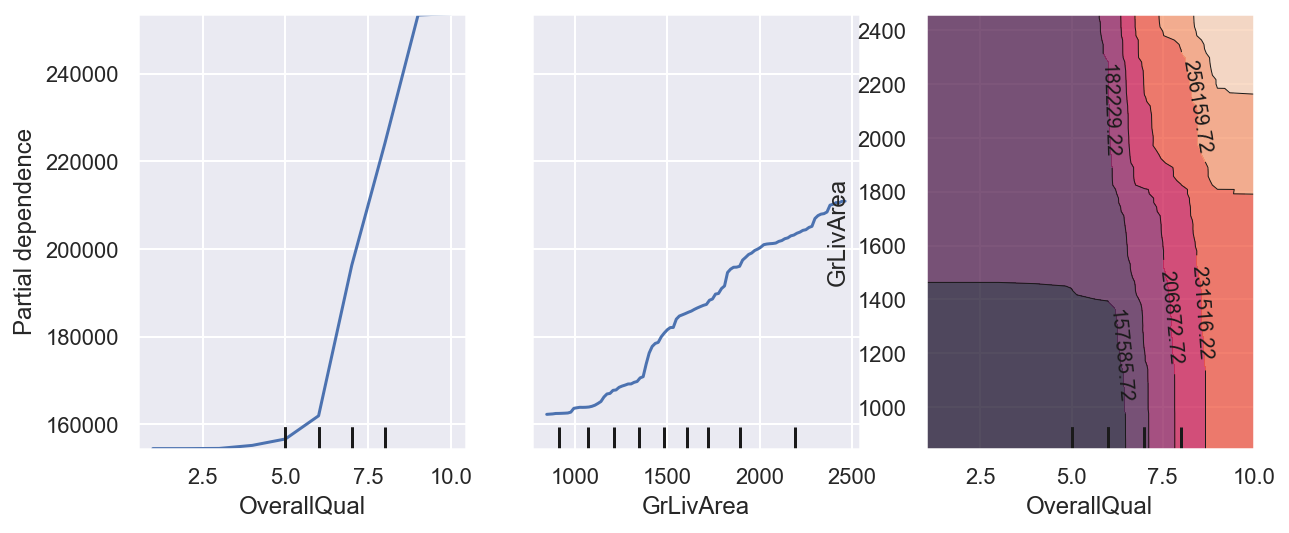

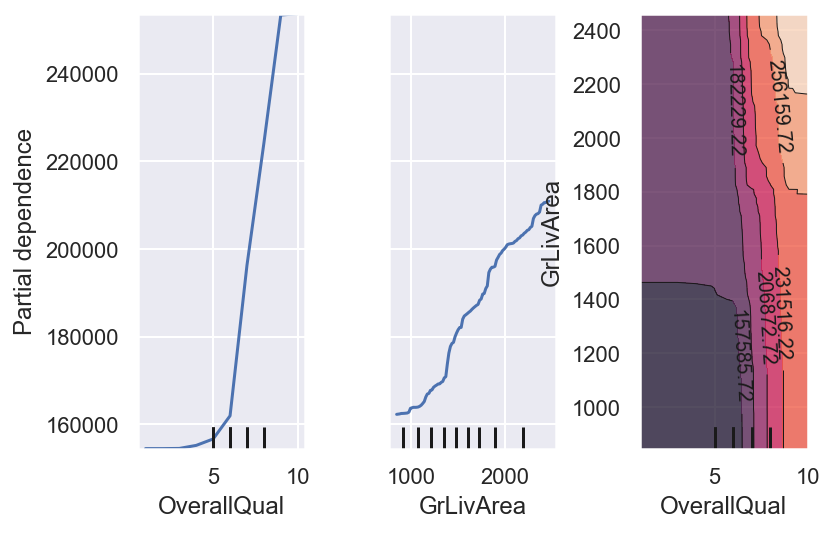

In [16]:
from sklearn.inspection import PartialDependenceDisplay

plt.figure(figsize=(10, 4))
ax = plt.gca()

# Caracteristicas a comparar
overall_qual = X_train.columns.get_loc('OverallQual')
gr_liv_area = X_train.columns.get_loc('GrLivArea')

# Calculo PDP para las variables 'OverallQual' y 'GrLivArea' por separado y juntas
features = [overall_qual, gr_liv_area, (overall_qual, gr_liv_area)]
pdp_ind = PartialDependenceDisplay.from_estimator(rforest, X_train, features=features, target=2, method='brute') # PDP (kind='average')
pdp_ind.plot(ax=ax)

plt.subplots_adjust(wspace=0.5)

## No se por qué me dibuja la gráfica dos veces.

___Comentario___

<br><font color='blue'>
    El gráfico muestra que tanto la variable 'OverallQual' como 'GrLivArea' tienen una relación positiva con la variable objetivo que se está tratando de predecir, es decir, a medida que aumentan estas variables, también lo hace la variable objetivo, controlando todos los demás factores.
    <br>
    En el caso de la variable 'OverallQual', la curva muestra un aumento acelerado al principio y luego se estabiliza, lo que indica que tiene un efecto más fuerte en la variable objetivo en comparación con 'GrLivArea'. Por otro lado, la curva de 'GrLivArea' es más lineal, tiene un efecto más constante en la variable objetivo.
    <br>
    En el gráfico combinado, se puede ver que la variable 'OverallQual' tiene una influencia mucho mayor en los valores de alrededor de 7 a 9, donde define áreas muy claras de la variable objetivo independientemente de 'GrLivArea'. Para valores de 'OverallQual' inferiores a 7, esta variable pierde su influencia y la que se vuelve importante es 'GrLivArea', pero con un rango mucho más amplio.

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

El gráfico anterior nos permite visualizar de forma global la relación de las variables con la salida. Imaginemos ahora que nos encontramos en la siguiente situación: una persona quiere poner a la venta su vivienda, pero el precio de venta que predecimos es más bajo del esperado. ¿Podemos explicarle el motivo de dicho resultado?


En este caso, se pretende expicar por qué obtenemos una predicción específica para una muestra específica. En estos casos, podemos utilizar SHAP para estudiar cómo los valores de las distintas variables afectan a la salida.

In [17]:
#!pip install shap

In [18]:
import shap

shap.initjs()

Vamos a estudiar algunas muestras individuales del conjunto de test para simular distintas situaciones. En concreto, vamos a seleccionar las muestras más cercanas a los percentiles 0, 0.25, 0.5, 0.75 y 1 (en cuanto a valor de *y*) en las predicciones del conjunto de test. El 0 corresponderá a la muestra con la predicción de precio más bajo, mientras que 1 sería la muestra de test con la predicción más alta.

In [19]:
y_pred = rforest.predict(X_test)
pcen = np.percentile(y_pred, [0, 25, 50, 75, 100], interpolation='nearest')
i_near = [abs(y_pred - i).argmin() for i in pcen]
samples = X_test.iloc[i_near, :]
samples.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1101,60.0,8400,2,5,1920,1950,0.0,290,0,0,...,0,0,0,1,0,0,0,0,1,0
377,57.0,8846,5,5,1996,1996,0.0,298,0,572,...,0,0,0,1,0,0,0,0,1,0
649,70.0,7700,6,5,1966,1966,351.0,0,0,756,...,0,0,0,1,0,0,0,0,1,0
472,92.0,11952,7,6,1977,1977,0.0,0,0,808,...,0,0,0,1,0,0,0,0,1,0
1183,160.0,15623,10,5,1996,1996,0.0,2096,0,300,...,0,0,0,1,1,0,0,0,0,0


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 5</font> 

Dibujar los gráficos de fuerzas SHAP para cada una de las 5 muestras seleccionadas. Comentar los resultados.

In [20]:
sample = 0

# Calculo los valores shap para la muestra 'sample'
explainer = shap.Explainer(rforest, X_test)
shap_values = explainer.shap_values(samples.iloc[sample, :])

# Dibujo el gráfico de fuerza 
shap.force_plot(explainer.expected_value, shap_values, samples.iloc[sample, :])

In [21]:
sample = 1

# Calculo los valores shap para la muestra 'sample'
explainer = shap.Explainer(rforest, X_test)
shap_values = explainer.shap_values(samples.iloc[sample, :])

# Dibujo el gráfico de fuerza 
shap.force_plot(explainer.expected_value, shap_values, samples.iloc[sample, :])

In [22]:
sample = 2

# Calculo los valores shap para la muestra 'sample'
explainer = shap.Explainer(rforest, X_test)
shap_values = explainer.shap_values(samples.iloc[sample, :])

# Dibujo el gráfico de fuerza 
shap.force_plot(explainer.expected_value, shap_values, samples.iloc[sample, :])

In [23]:
sample = 3

# Calculo los valores shap para la muestra 'sample'
explainer = shap.Explainer(rforest, X_test)
shap_values = explainer.shap_values(samples.iloc[sample, :])

# Dibujo el gráfico de fuerza 
shap.force_plot(explainer.expected_value, shap_values, samples.iloc[sample, :])

In [24]:
sample = 4

# Calculo los valores shap para la muestra 'sample'
explainer = shap.Explainer(rforest, X_test)
shap_values = explainer.shap_values(samples.iloc[sample, :])

# Dibujo el gráfico de fuerza 
shap.force_plot(explainer.expected_value, shap_values, samples.iloc[sample, :])

___Comentario___

<br><font color='blue'>
    El gráfico muestra cómo los valores de las distintas variables afectan al precio de las casas en las distintas muestras. En la primera muestra, el precio predecido es de alrededor de 70 mil euros y se puede observar que los valores de todas las variables tienen una influencia negativa en el precio, siendo 'OverallQual' y 'GrLivArea' las más importantes en términos de su impacto negativo en el precio.<br>
    A medida que avanzamos a las siguientes muestras, podemos observar cómo algunos valores de las variables comienzan a influir positivamente en el precio, lo que resulta en un aumento en el precio predecido. Este patrón continúa hasta llegar a la muestra con el precio más alto de más de 490 mil euros, donde todos los valores de las variables tienen una influencia positiva en el precio.<br>
    En general, se puede notar que las variables 'OverallQual' y 'GrLivArea' tienen la mayor influencia en el precio en todas las muestras, lo cual no es sorprendente ya que son dos de las variables más importantes en el modelo de regresión utilizado.

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 6</font> 

Dibuja un resumen global de los valores SHAP de todas las muestras de test con `summary_plot`. Comentar los resultados.

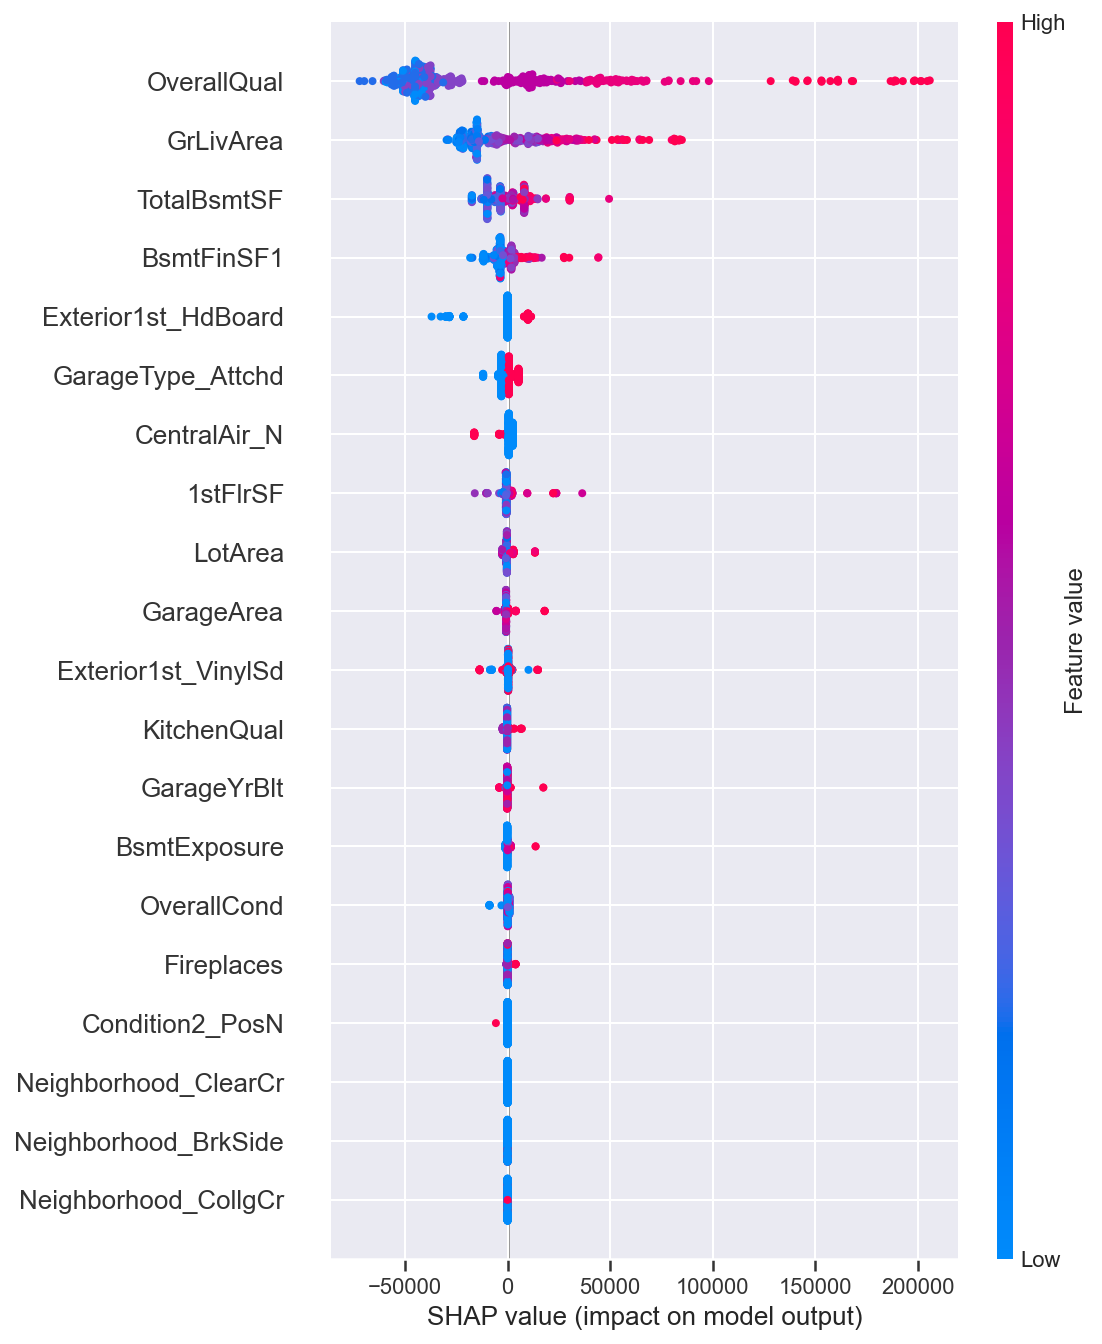

In [25]:
# Calculo de los valores SHAP
explainer = shap.Explainer(tree, X_test)
shap_values = explainer(X_test)

# Resumen global de los valores SHAP
shap.summary_plot(shap_values, X_test)

___Comentario___

<br><font color='blue'>
    Como pudimos observar en las muestras previas, las variables que tienen mayor influencia en la predicción del precio son 'OverallQual' y 'GrLivArea'. Es decir, estas dos variables son las que tienen una mayor capacidad para afectar el resultado final y, por lo tanto, son de gran importancia en la predicción del precio de una vivienda.

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section7"></a>
## <font color="#00586D"> 7. KNN</font>
<br>

Anteriormente se han usado algunos métodos paramétricos (regresión) y no paramétricos (árboles y *Random Forest*) para la predicción. KNN es otro método no paramétrico muy sencillo.


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 7</font> 

Entrenar un modelo de predicción utilizando el vecino más cercano. Como el conjunto de datos no es excesivamente alto en relación a las características, y este algoritmo es muy sensible a la "*Maldición de la dimensionalidad"*, en esta prueba se utilizarán solamente las características numéricas relevantes obtenidas anteriormente con *Random Forest*, y almacenadas en `relevant_feat` durante el proceso de exploración.  

In [26]:
from sklearn.neighbors import KNeighborsRegressor

# Selecciono solo las características relevantes en X_train y X_test
X_train_relevant = X_train[relevant_feat]
X_test_relevant = X_test[relevant_feat]

# Creo un objeto KNeighborsRegressor con k=1 (vecino más cercano)
k = 1
knn = KNeighborsRegressor(n_neighbors = k)

# Entreno el modelo utilizando X_train_relevant y y_train
knn.fit(X_train_relevant, y_train)

# Descripción del modelo
description = '1-NN (Relevant)'

# Muestra los resultados
show_results(description, knn, X_train_relevant, y_train, X_test_relevant, y_test)

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 1.000		R² = 0.504		R² = 0.633
MAE = 0.00					MAE = 32280.27


Puede apreciarse que el rendimiento de este algoritmo es muy pobre ($R^2=0.504$ en validación). A continuación se creará un *pipeline* para estandarizar los datos antes de hacer la predicción.

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_neighbors = k))]) 
pipe_knn.fit(X_train_relevant, y_train) 


description = '1-NN (Relevant-STD)'
show_results(description, pipe_knn, X_train_relevant, y_train, X_test_relevant, y_test)

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 1.000		R² = 0.715		R² = 0.704
MAE = 0.00					MAE = 27428.49


En este caso, sube de manera sustancial el $R^2$ para el conjunto de validación. ¿Qué sucece?

___Comentario___

<br><font color='blue'>
    Se logra una mejora significativa en el rendimiento del modelo al estandarizar los datos. En este caso, la estandarización es especialmente importante ya que el algoritmo KNN se basa en el cálculo de distancias, y aquellas variables con una mayor magnitud pueden tener un gran impacto en el resultado del modelo si no se estandarizan. Por lo tanto, la estandarización ayuda a igualar el impacto de todas las variables y a mejorar la precisión del modelo en la predicción del precio de la vivienda.


<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 8</font> 

Analizar el funcionamiento de KNN con distintos valores para `k`, utilizando pesos uniformes o inversos a la distancia para agregar los valores de los vecinos. En primer lugar, utilizando **todas las variables** (`X_train`) y estandarización.

In [28]:
pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor())])

parameters = {'knn__n_neighbors':(1,5,10,15,20), 'knn__weights':('uniform','distance')}
search = GridSearchCV(pipe_knn, parameters, cv=5).fit(X_train, y_train)
print(search.best_params_, end='\n\n')

knn = search.best_estimator_
description = 'k-NN (STD)'
show_results(description, knn, X_train, y_train, X_test, y_test)

{'knn__n_neighbors': 10, 'knn__weights': 'distance'}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 1.000		R² = 0.732		R² = 0.698
MAE = 0.00					MAE = 25710.12


Puede hacerse la predicción utilizando solamente las características relevantes obtenidas con `Random Forest` (`relevant_feat`).

In [29]:
pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor())])

parameters = {'knn__n_neighbors':(1,5,10,15,20), 'knn__weights':('uniform','distance')}
search = GridSearchCV(pipe_knn, parameters, cv=5).fit(X_train_relevant, y_train)
print(search.best_params_, end='\n\n')
knn = search.best_estimator_

description = 'k-NN (STD - Relevant)'
show_results(description, knn, X_train_relevant, y_train, X_test_relevant, y_test)

{'knn__n_neighbors': 5, 'knn__weights': 'distance'}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 1.000		R² = 0.803		R² = 0.796
MAE = 0.00					MAE = 21230.95


Comparar y comentar los resultados de ambas pruebas.

___Comentario___

<br><font color='blue'>
    Podemos ver que utilizando todas las variables y estandarización, el mejor modelo de k-NN encontrado por GridSearchCV tiene un R2 de 0.698 en el conjunto de prueba, mientras que al utilizar únicamente las características relevantes obtenidas con Random Forest, el R2 del modelo encontrado es de 0.796. Esto indica que al utilizar únicamente las características más importantes en el modelo, se consigue una mayor precisión en las predicciones. Además, es más robusto, ya que su R2 en el conjunto de validación es mayor que el obtenido con todas las variables (0.803 vs 0.732).
    <br>
    Al utilizar todas las variables, las características irrelevantes también contribuyen al cálculo de las distancias, lo que puede afectar negativamente el rendimiento del modelo. Por lo tanto, la selección de características relevantes no solo mejora la precisión de las predicciones, sino que también puede ayudar a evitar que el modelo esté sobreajustado y a mejorar su capacidad de generalización. 

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section8"></a>
## <font color="#00586D"> 8. Construcción de características</font>
<br>

La construcción de características puede llevarse a cabo de varias formas. Un enfoque es el que se apoya en una construcción exhaustiva, como por ejemplo se puede hacer con el módulo *Feature Creation* de la librería `feature-engine`[**(+ Inf)**](https://feature-engine.readthedocs.io/en/latest/index.html), seguida de selección; un segundo enfoque se basa en la construcción mediante técnicas más complejas, como la programación genética+autoML; por último, también es posible construir características de manera manual a partir de la exploración. En este proyecto utilizaremos este último enfoque para construir algunas características sencillas. Para ello utilizaremos un conjunto de datos auxiliar, al que denominaremos `data_feat()`.

In [30]:
data_feat = data.copy()

Durante la exploración se observó que la distribución del precio de venta está claramente sesgada. En estos casos, es conveniente trabajar con el logaritmo. 

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 9</font> 

Calcular el logaritmo de los valores de la columna `data_feat['SalePrice'] `, almacenar el resultado en `data_feat['SalePrice']` y visualizar la distribución con una gráfica de  tipo `histplot`.

In [31]:
data_feat['SalePrice'] = np.log(data_feat['SalePrice'])

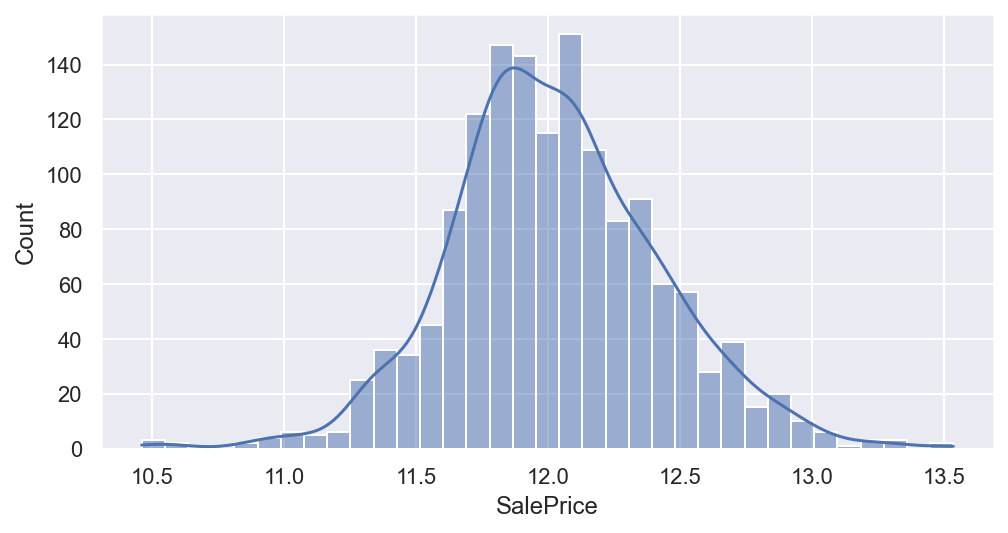

In [32]:
plt.figure(figsize=(8, 4))
sns.histplot(data=data_feat['SalePrice'], kde=True);

También se ha observado que la relación de la variable `OveralQuality`, una de las más correlacionadas, era más fuerte con respecto al logaritmo de la variable `SalesPrice`.

Otra variable imortante, `GrLivArea`, también está sesgada. Sustituirla también por su logaritmo.

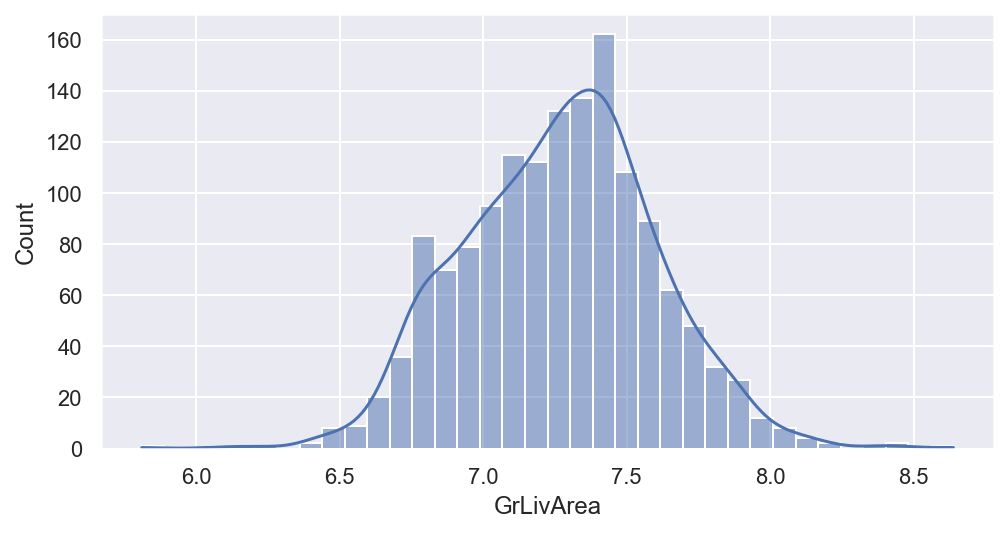

In [33]:
data_feat['GrLivArea'] = np.log(data_feat['GrLivArea'])
plt.figure(figsize=(8, 4))
sns.histplot(data=data_feat['GrLivArea'], kde=True);

Por último, algunas variables numéricas representan datos temporales. Por ejemplo, en este conjunto de datos, el mes de venta. Aunque su repercursión no es muy fuerte, es conveniente saber tratar estas variables, ya que aparecen a menudo en distintos consumos de datos. A continuación se muestra la distribución de los precios en función del mes. 

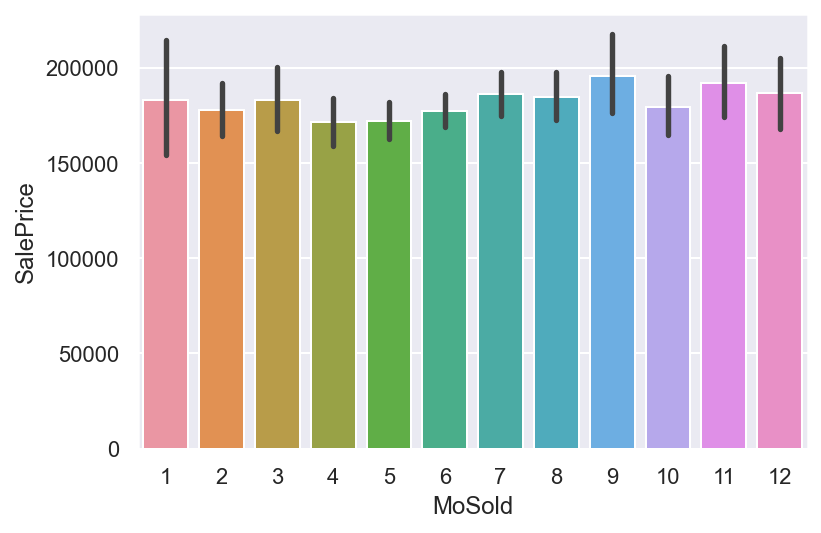

In [34]:
data_feat.sort_values(by='MoSold', inplace=True)
ax = sns.barplot(x=data_feat['MoSold'].astype('str'), y=data['SalePrice']);

Puede observarse que existe cierta oscilación en los precios y que depende del mes. También que el mes 1 y el 12, que representan valores extremos, realmente deberían ser similares, porque se suceden en el tiempo y, además, los precios medios son similares también. Vemos que los precios bajan en mayo y junio, y crecen en septiembre-noviembre. Estas particularidades no se representan mediante una relación lineal, pero se pueden representar mejor con una función sinusoidal.

(1.0, 13.0)

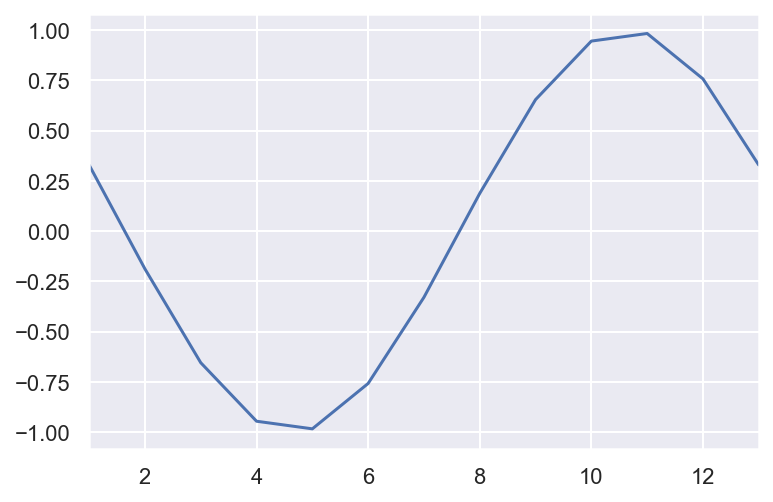

In [35]:
t = np.linspace(1, 13, 13, endpoint=True)
ft = np.sin(2*np.pi*t/12-4)

plt.plot(t,ft)
plt.xlim(1,13)

Sustituir los valores de la columna `data_feat['MoSold']` por los obtenidos al calcular la función sinusoidal anterior.

In [36]:
ft_tiled = np.tile(ft, int(data_feat.shape[0]/13) + 1)[:data_feat.shape[0]]
data_feat['MoSold'] = ft_tiled

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

Una vez transformadas las tres variables, se volverán a obtener los conjuntos de entrenamiento y test, ahora con algunas características transformadas.

In [37]:
from sklearn.model_selection import train_test_split

X = data_feat.drop(columns='SalePrice').copy()
y = data_feat['SalePrice'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 10</font> 

Volver a obtener los modelos de regresión lineal y árbol de regresión utilizando los conjuntos de datos obtenidos al transformar las características. Mostrar los resultados (visualizar el *DataFrame* `results`), y comentarlos.

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
Como la variable `SalePrice` es ahora un logaritmo, es necesario deshacer esa transformación para hacer el MAE. Esto solo implica pasar el argumento `is_log=True` a la función `show_results`. 
<br>

Para KNN, utilizad el *pipeline* para estandarizar los datos, y solo las características incluídas en `relevant_feat`.
</div>

In [38]:
# Modelo de Regresión Ridge 

parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(random_state=0), parameters, cv=5).fit(X_train, y_train)
print(search.best_params_, end='\n\n')

ridge = search.best_estimator_
description = 'Ridge regression (FT)'
show_results(description, ridge, X_train, y_train, X_test, y_test, is_log=True)

{'alpha': 10.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.938		R² = 0.899		R² = 0.834
MAE = 12314.72					MAE = 17967.54


In [39]:
# Modelo de Árbol de Regresión

parameters = {'max_depth':np.linspace(1,15,15), 'min_samples_split':(2,4,6,8,10)}
search = GridSearchCV(DecisionTreeRegressor(random_state=0), parameters, cv=5).fit(X_train, y_train)
print(search.best_params_, end='\n\n')

tree = search.best_estimator_
description = 'Regression tree (FT)'
show_results(description, tree, X_train, y_train, X_test, y_test, is_log=True)

{'max_depth': 8.0, 'min_samples_split': 10}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.949		R² = 0.755		R² = 0.721
MAE = 12318.48					MAE = 26543.01


In [40]:
# Modelo de Ramdom Forest

parameters = {'max_depth':[1,5,10,15,20]}
search = GridSearchCV(RandomForestRegressor(random_state=0), parameters, cv=5).fit(X_train, y_train)
print(search.best_params_, end='\n\n')

rforest = search.best_estimator_
description = 'Random forest (FT)'
show_results(description, rforest, X_train, y_train, X_test, y_test, is_log=True)

{'max_depth': 20}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.982		R² = 0.866		R² = 0.861
MAE = 6800.31					MAE = 18670.09


In [41]:
# Modelo de KNN

pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor())])

parameters = {'knn__n_neighbors':(1,5,10,15,20), 'knn__weights':('uniform','distance')}
search = GridSearchCV(pipe_knn, parameters, scoring='neg_mean_absolute_error', n_jobs=-1).fit(X_train[relevant_feat], y_train)
print(search.best_params_, end='\n\n')
knn = search.best_estimator_

description = 'k-NN (STD - Relevant - FT)'
show_results(description, knn, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test, is_log=True)

{'knn__n_neighbors': 10, 'knn__weights': 'distance'}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 1.000		R² = 0.813		R² = 0.800
MAE = 0.00					MAE = 22364.68


In [42]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Ridge regression,0.907758,0.845827,0.775932,15187.837606,19274.550173
Regression tree,0.877226,0.719639,0.746637,20590.843457,26399.467551
Random forest,0.979642,0.857511,0.857280,6669.429578,17147.713288
Ridge regression (Relevant),0.834756,0.817096,0.711741,21103.544463,22491.444235
Regression tree (Relevant),0.955836,0.717987,0.633461,12505.428221,26932.153168
Random forest (Relevant),0.974762,0.846168,0.852680,8262.941225,18350.175277
1-NN (Relevant),1.000000,0.503804,0.633216,0.000000,32280.269710
1-NN (Relevant-STD),1.000000,0.715466,0.703768,0.000000,27428.493776
k-NN (STD),1.000000,0.732469,0.698286,0.000746,25710.122559


___Comentario___

<br><font color='blue'>
    Se puede observar una evolución en la predicción de los modelos a medida que se van aplicando mejoras y ajustes. Los modelos más simples, como la regresión de Ridge y el árbol de regresión, tienen un desempeño decente, pero son superados por modelos más avanzados como el Random Forest y el k-NN con selección de características y ajuste de hiperparámetros. Estos modelos más avanzados logran capturar mejor las complejidades de los datos y producen predicciones más precisas. <br>
    La selección de características y el ajuste de hiperparámetros son elementos clave para mejorar el desempeño de los modelos.

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section9"></a>
## <font color="#00586D"> 9. Descarte de outliers</font>
<br>

Llegado a este punto se aprecia que el mejor resultado se ha obtenido con la regresión regularizada (nos basamos en la validación para la selección de modelos), tras transformar algunas características, y utilizando todas las demás.  En algunos casos, los valores anómalos pueden perjudicar al modelo. En regresión, por ejemplo, pueden hacer que algún coeficiente se altere de manera sustancial, sobre todo si el conjunto de datos no es grande.

Por último, se comprobará el efecto de eliminar valores anómalos. 




#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 11</font> 

Utilizar un modelo *Isolation Forest* para "marcar" las muestras que son *outliers*, tanto en el conjunto de entrenamiento como en el conjunto de test. Utilizar una contaminación del 0.5%.  Generar dos vectores (`out_train` y `out_test`) con los resultados (1 para valores normales, y -1 para *outliers*). ¿Cuantos *outliers* hay en el conjunto de entrenamiento? ¿Y en el de test?

In [43]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(contamination=0.005, random_state=0).fit(X_train)
out_train = iforest.predict(X_train)
out_test = iforest.predict(X_test)

print("Número de outliers en el conjunto de entrenamiento:", len(out_train[out_train==-1]))
print("Número de outliers en el conjunto de test:", len(out_test[out_test==-1]))

X does not have valid feature names, but IsolationForest was fitted with feature names


Número de outliers en el conjunto de entrenamiento: 5
Número de outliers en el conjunto de test: 4


<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 12</font> 

Eliminar los outliers  de los conjuntos de entrenamiento y test, y entrenar el modelo de regresión lineal regularizada (el mejor modelo hasta el momento). ¿Qué resultados se obtienen?

In [44]:
# Elimino los outliers del conjunto de entrenamiento
X_train_no_out = X_train[out_train == 1]
y_train_no_out = y_train[out_train == 1]

# Elimino los outliers del conjunto de prueba
X_test_no_out = X_test[out_test == 1]
y_test_no_out = y_test[out_test == 1]

parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(random_state=0), parameters, scoring='neg_mean_absolute_error', n_jobs=-1).fit(X_train_no_out, y_train_no_out)
print(search.best_params_, end='\n\n')

ridge = search.best_estimator_
description = 'Ridge regression (FT - No Outliers)'
show_results(description, ridge, X_train_no_out, y_train_no_out, X_test_no_out, y_test_no_out, False)

{'alpha': 10.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.946		R² = 0.918		R² = 0.914
MAE = 0.07					MAE = 0.08


In [45]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Ridge regression,0.907758,0.845827,0.775932,15187.837606,19274.550173
Regression tree,0.877226,0.719639,0.746637,20590.843457,26399.467551
Random forest,0.979642,0.857511,0.857280,6669.429578,17147.713288
Ridge regression (Relevant),0.834756,0.817096,0.711741,21103.544463,22491.444235
Regression tree (Relevant),0.955836,0.717987,0.633461,12505.428221,26932.153168
Random forest (Relevant),0.974762,0.846168,0.852680,8262.941225,18350.175277
1-NN (Relevant),1.000000,0.503804,0.633216,0.000000,32280.269710
1-NN (Relevant-STD),1.000000,0.715466,0.703768,0.000000,27428.493776
k-NN (STD),1.000000,0.732469,0.698286,0.000746,25710.122559


___Comentario___

<br><font color='blue'>
    Después de eliminar los outliers de los conjuntos de entrenamiento y test, el modelo Ridge regression mejora en todos los indicadores. Además, se obtuvieron valores de error absoluto medio cercanos a 0 tanto en el conjunto de entrenamiento como en el conjunto de test, lo que indica una mayor precisión en las predicciones del modelo.
    <br>
    La eliminación de los outliers mejora la calidad de los modelos predictivos, ya que los outliers pueden tener un impacto desproporcionado en la estimación de los parámetros del modelo.

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
__Importante__: Incorporar este paso al pipeline sería bastante complejo porque no solo modificamos columnas, sino que eliminamos filas. Habría que hacer un *metaclasificador* que primero determine si un valor es un outlier o no, y en función de eso devuelva el resultado (que puede ser -1 para un caso, y la predicción para otro). La implementación de este *pipeline* constituye un ejercicio interesante.
</div>

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section10"></a>
## <font color="#00586D">10. Aprendizaje no supervisado: PCA, Manifold y EM</font>
<br>

Para analizar el conjunto de datos mediante aprendizaje no supervisado se partirá del conjunto de datos original. En este caso trabajaremos solamente con las caracterícticas numéricas más relevantes y el precio.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> Estos ejercicios **no son una continuación** de los relacionados con el modelo predictivo, sino que constituyen una estudio independiente. 
</div>

In [46]:
feat = ['OverallQual',
        'GrLivArea',
        'ExterQual',
        'KitchenQual',
        'GarageArea',
        'TotalBsmtSF',
        '1stFlrSF',
        'TotRmsAbvGrd',
        'YearBuilt',
        'SalePrice']

data_small = data[feat]
data_small.head()

,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageArea,TotalBsmtSF,1stFlrSF,TotRmsAbvGrd,YearBuilt,SalePrice
Id,,,,,,,,,,
1,7,1710,4,4,548,856,856,8,2003,208500
2,6,1262,3,3,460,1262,1262,6,1976,181500
3,7,1786,4,4,608,920,920,6,2001,223500
4,7,1717,3,4,642,756,961,7,1915,140000
5,8,2198,4,4,836,1145,1145,9,2000,250000


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 13</font>

Utilizar PCA para reducir la dimensionalidad del conjunto de datos `data`. Utilizar dos componentes y almacenar la proyección en una variable denominada `data_pc`. Mostrar la proporción de varianza mostrada por cada componente. Dibujar una gráfica de dispersión con los valores de las dos primeras características creadas (proyecciones correspondientes a las dos componentes). ¿Qué se observa? (Se puede utilizar como color, por ejemplo, `hue=data['SalePrice']`).

Número de componentes: 2
Varianza mostrada por cada componente: [0.98536696 0.01444069]


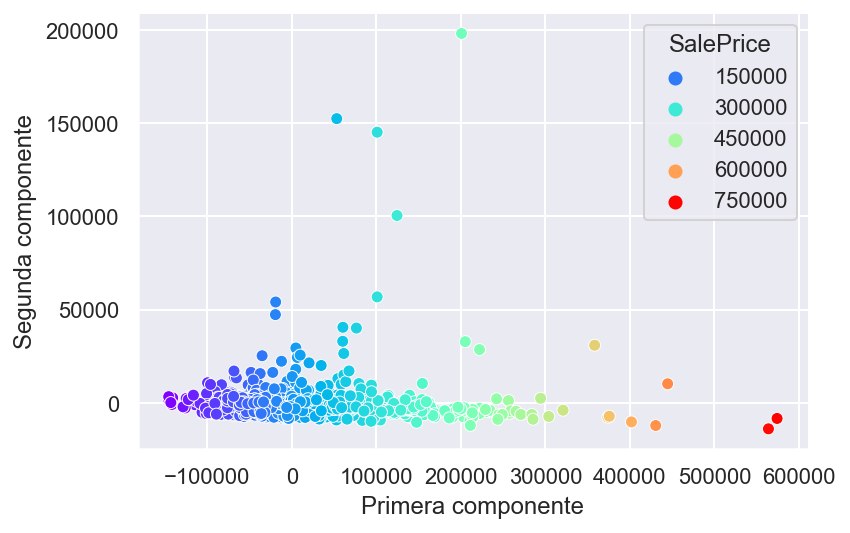

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pc = pca.fit_transform(data)

print(f'Número de componentes: {data_pc.shape[1]}')
print(f'Varianza mostrada por cada componente: {pca.explained_variance_ratio_}')

# Dibujo la grafica
sns.scatterplot(x=data_pc[:, 0], y=data_pc[:, 1], hue=data['SalePrice'], palette='rainbow')
sns.set_style("white")
sns.despine()
plt.xlabel('Primera componente')
plt.ylabel('Segunda componente')
plt.show()

Muestra las cargas de las dos componentes (los 5 valores más importantes)

In [48]:
sorted(zip(data_small.columns,pca.components_[0]), key=lambda pair: pair[1], reverse=True)[:5]

[('GrLivArea', 0.03362409628154592),
 ('TotRmsAbvGrd', 0.0022199923847840445),
 ('SalePrice', 0.0011909079224507717),
 ('1stFlrSF', 0.0010743693706679305),
 ('GarageArea', 0.00019848004498861527)]

In [49]:
sorted(zip(data_small.columns,pca.components_[1]), key=lambda pair: pair[1], reverse=True)[:5]

[('GrLivArea', 0.9993707393918536),
 ('TotRmsAbvGrd', 0.005454815975636837),
 ('YearBuilt', 0.001986594902341792),
 ('OverallQual', 0.0005101855246464143),
 ('KitchenQual', 1.8194202711147152e-06)]

___Comentario___

<br><font color='blue'>
    El análisis de componentes principales aplicado al conjunto de datos muestra que las dos primeras componentes acumulan casi toda la varianza de los datos, lo que significa que se puede explicar la mayoría de la variabilidad en el conjunto de datos con solo dos variables. <br>
    La característica más importante para explicar la varianza en la primera componente es 'GrLivArea', seguida de 'TotRmsAbvGrd'. Aunque 'SalePrice' también contribuye a explicar la variabilidad de los datos, su impacto es mucho menor que las dos anteriores. <br>
    En la segunda componente, se destaca la importancia de 'GrLivArea', mientras que 'TotRmsAbvGrd' tiene una menor influencia en comparación con la primera componente. <br>
    La reducción de dimensionalidad proporcionada por el PCA es significativa y puede ayudar a simplificar la exploración y análisis de datos.

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 14</font>




Construir un *pipeline* en el que el primer paso consista en escalar las características a media cero y desviación uno mediante un objeto `StandardScaler`, y después se  repita el proceso anterior, almacenando la proyección de los datos en `data_pc`. Mostrar el número de componentes necesarias para retener el 99% de la varianza de los datos. ¿Son ahora tan relevantes las dos primeras componentes? ¿Por qué? ¿Cuánta varianza acumulan? ¿Podrían interpretarse de algún modo?

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe_sc_pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=0.99, svd_solver='full'))])
data_pc = pipe_sc_pca.fit_transform(data_small)
pca = pipe_sc_pca.named_steps['pca']

print(f'Número de componentes: {data_pc.shape[1]}')
print('Varianza explicada acumulada:', np.cumsum(pca.explained_variance_ratio_))

Número de componentes: 10
Varianza explicada acumulada: [0.56500482 0.70361196 0.79915492 0.85408061 0.89649085 0.92695371
 0.95310594 0.97170598 0.98738782 1.        ]


In [51]:
print('Cargas de la primera componente: ')
sorted(zip(data_small.columns, pca.components_[0]), key=lambda pair: pair[1], reverse=True)[:5]

Cargas de la primera componente: 


[('SalePrice', 0.38282241839673714),
 ('OverallQual', 0.36205137652326347),
 ('ExterQual', 0.33080533313143884),
 ('KitchenQual', 0.31772664306577747),
 ('GrLivArea', 0.31754078332179037)]

In [52]:
print('Cargas de la segunda componente: ')
sorted(zip(data_small.columns, pca.components_[1]), key=lambda pair: pair[1], reverse=True)[:5]

Cargas de la segunda componente: 


[('TotRmsAbvGrd', 0.5520895000574141),
 ('GrLivArea', 0.46247291403631824),
 ('1stFlrSF', 0.23299064714707),
 ('TotalBsmtSF', 0.054819980351437314),
 ('SalePrice', 0.026981868237818347)]

___Comentario___

<br><font color='blue'>
    En comparación con los resultados anteriores, se puede observar que las variables con los valores más altos han cambiado. Además, hay una mayor distribución de la varianza en las diferentes componentes.<br>
    La primera componente principal tiene valores altos de SalePrice, OverallQual, ExterQual, KitchenQual y GrLivArea, lo que sugiere una gran relación entre estas variables. 
    La segunda componente principal muestra una alta correlación entre TotRmsAbvGrd y GrLivArea. <br>
    En términos de la varianza acumulada, la primera y segunda componentes explican el 70,36% de la varianza total, es decir, estas dos componentes explican una cantidad significativa de la variación en los datos.

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 15</font>

Repetir el ejercicio anterior, pero utilizando ahora TSNE. Para ello, crear un *pipeline* en el que el primer paso corresponda a la estadarización, y el segundo a un modelo TSNE en el que `n_components=2`. Utilizarlo para transformar los datos en `data_small` y almacenar el resultado en un array denominado `data_vis`.

In [53]:
from sklearn.manifold import TSNE

pipe_sc_tsne = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2))])
data_vis = pipe_sc_tsne.fit_transform(data_small)

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


Elaborar una gráfica de dispersión con los datos de `data_vis`.

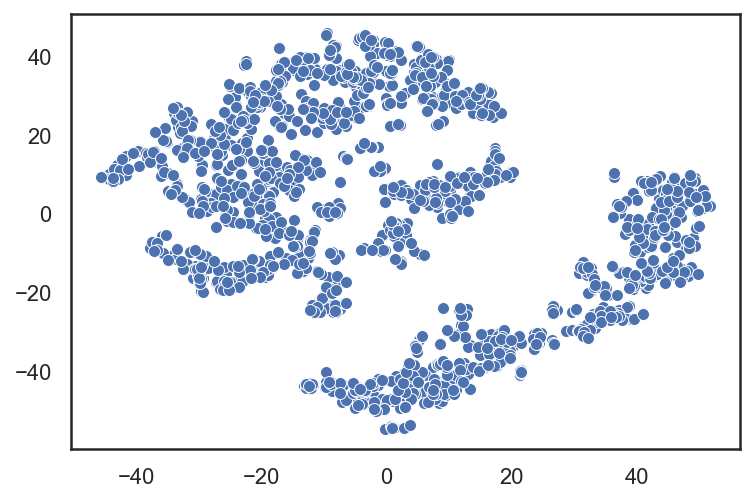

In [54]:
sns.scatterplot(x=data_vis[:, 0], y=data_vis[:, 1]);

Repetir la gráfica, pero utilizando `hue=data['SalePrice']` 

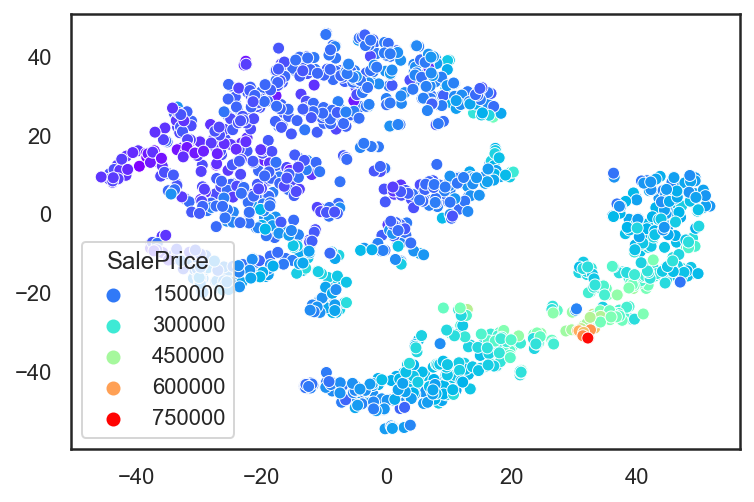

In [55]:
sns.scatterplot(x=data_vis[:,0], y=data_vis[:,1], hue=data['SalePrice'], palette='rainbow');

Probar a utilizar el color para mostrar otra variables, como por ejemplo `YearBuilt`.

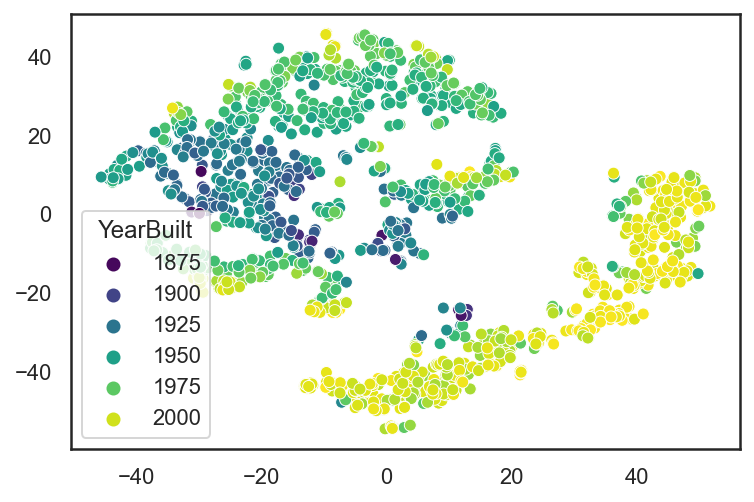

In [56]:
sns.scatterplot(x=data_vis[:, 0], y=data_vis[:, 1], hue=data['YearBuilt'], palette='viridis');

___Comentario___

<br><font color='blue'>
    Aunque no hay una separación muy evidente, parece que los pisos más baratos se encuentran en el grupo de los edificios construidos antes del año 2000. Quizas los compradores pueden verse influidos por la antigüedad del edificio y podrían tener una preferencia por construcciones más recientes.

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 16</font>

Por último, se va a utilizar el algoritmo EM (modelo `GaussianMixture`) para representar la distribución de las viviendas que hay en `data_small`, y utilizando `n_components=2`.   En este caso, también es necesario utilizar un *pipeline* en el que el primer paso consista en una estandarización, y el segundo el propio algoritmo. Almacenar el cluster al que pertenece cada vivienda en `cluster`.

In [57]:
from sklearn.mixture import GaussianMixture

pipe_sc_gm = Pipeline([('scaler', StandardScaler()), ('gm', GaussianMixture(n_components=2))])
cluster = pipe_sc_gm.fit_predict(data_small)

Obtener la media de todas las columnas para cada uno de los grupos y compararlos. ¿Puede hacerse algún tipo de interpretación?

In [58]:
data_small.groupby(cluster).mean()

,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageArea,TotalBsmtSF,1stFlrSF,TotRmsAbvGrd,YearBuilt,SalePrice
0,7.241441,1775.333333,4.041441,4.055856,594.533333,1277.926126,1318.531532,7.023423,1993.962162,240985.073874
1,5.398895,1356.096133,3.000000,3.177901,398.436464,922.207735,1067.016575,6.207735,1957.350276,144086.441989


Otra forma de interpretar los clusters es mediante visualización. Mostrar una gráfica de dispersión con las columnas `GrLivArea` y `SalePrice`. Utilizar  `hue=cluster`. ¿Puede hacerse algún tipo de interpretación? 

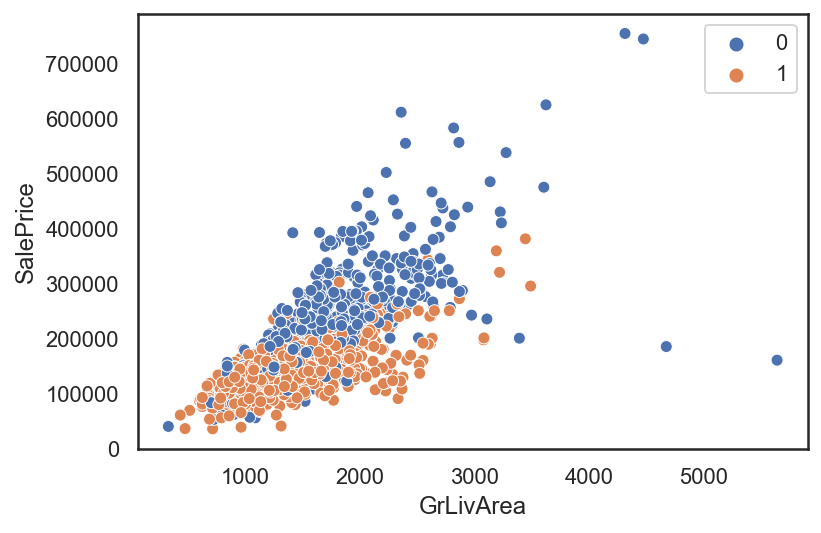

In [59]:
sns.scatterplot(x=data_small['GrLivArea'], y=data_small['SalePrice'], hue=cluster);

Elaborar ahora una gráfica de dispersión, pero con los datos de `data_pc`, utilizando otra vez `hue=cluster`. ¿Puede hacerse algún tipo de interpretación? 

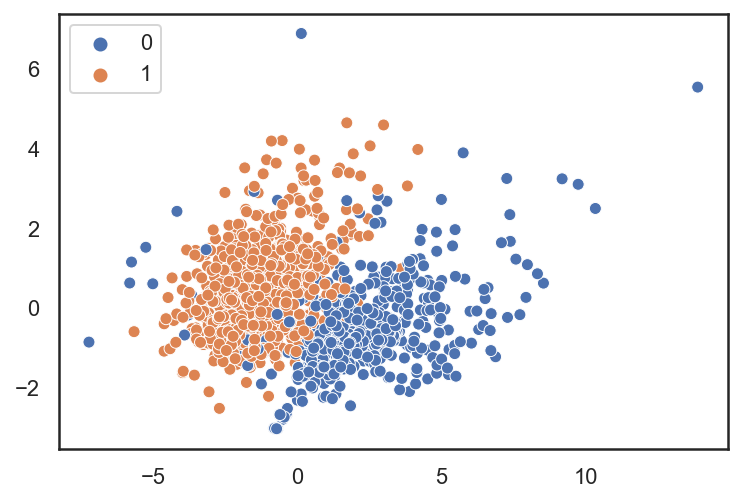

In [60]:
sns.scatterplot(x=data_pc[:, 0], y=data_pc[:, 1], hue=cluster);

Repetir la gráfica, pero con los datos en `data_vis`. ¿Puede hacerse algún tipo de interpretación? 

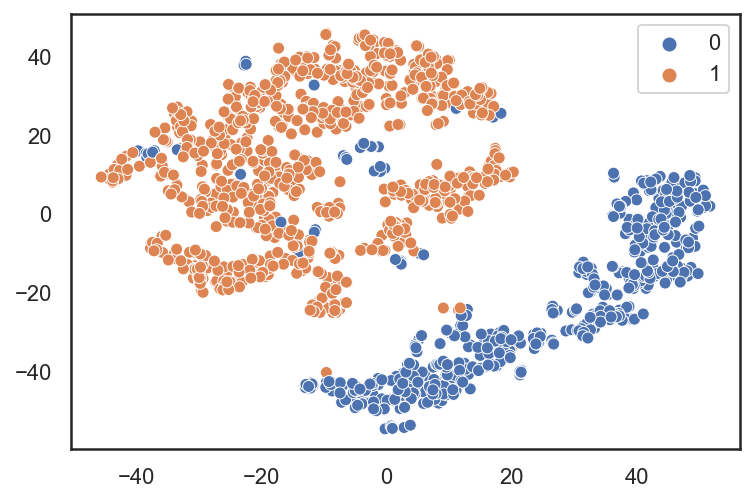

In [61]:
sns.scatterplot(x=data_vis[:, 0], y=data_vis[:, 1], hue=cluster);

___Comentario___

<br><font color='blue'>
    En el diagrama de dispersión de GrLivArea y SalePrice, podemos observar una tendencia lineal de unos 45 grados y una separación entre los pisos de venta por encima y por debajo de los 200 mil euros. <br>
    En el segundo gráfico, hay dos grupos bien definidos y cercanos entre sí con una zona de solapamiento entre ellos. <br>
    En el tercer gráfico, podemos observar la misma separación que el ejercicio anterior, en donde se muestra la diferencia entre los pisos construidos antes y después del año 2000, así como la división entre los pisos de menor y mayor precio de venta (aproximadamente por encima o por debajo de los 200 mil euros).


<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<div align="right">
<a href="#indice"><font size=6 color="#00586D"><i class="fa fa-coffee" aria-hidden="true"></i></font></a>
</div>